# Projet 10 - Système de Recommandation My Content
## 1. Configuration et Exploration des Données

### 🎯 Objectif de ce notebook
1. Télécharger et décompresser automatiquement le dataset Globo.com
2. Explorer la structure des données
3. Analyser les patterns d'interactions utilisateurs
4. Préparer les données pour le système de recommandation

## 1.0 Contexte Business et Objectifs

### 🎯 Contexte My Content
- **Entreprise** : Startup de recommandation de contenu personnalisé
- **Mission** : Développer un MVP pour tester le marché
- **Objectif** : Recommander 5 articles pertinents par utilisateur
- **Contrainte** : Pas de données propriétaires → utilisation dataset Globo.com

### 🎯 Défis Techniques Identifiés
1. **Cold Start Problem** : Majorité d'utilisateurs avec peu d'interactions
2. **Sparsité Extrême** : Matrice user-item quasi-vide
3. **Scalabilité** : Architecture cloud serverless requise
4. **Budget** : Optimisation pour Azure Functions gratuit

### 📊 Métriques de Succès
- Couverture : 100% des utilisateurs (même nouveaux)
- Diversité : >80% pour éviter la filter bubble
- Performance : <500ms de temps de réponse
- Coût : Compatible avec tier gratuit Azure

## 1.1 Installation des dépendances

In [1]:
## 1.1 Installation des dépendances

# Installation des packages nécessaires
import subprocess
import sys

def install_packages():
    """Installe les packages nécessaires si non présents"""
    packages = [
        'pandas>=2.0.0',
        'numpy>=1.24.0',
        'scikit-learn>=1.3.0',
        'matplotlib>=3.7.0',
        'seaborn>=0.12.0',
        'plotly>=5.14.0',
        'scikit-surprise>=1.1.3',
        'implicit>=0.7.0',
        'lightfm>=1.17',
        'requests>=2.31.0',
        'tqdm>=4.65.0',
        'jupyterlab-execute-time',  # Pour voir le temps d'exécution
    ]
    
    for package in packages:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        except:
            print(f"⚠️ Impossible d'installer {package}")
    
    print("✅ Packages installés")

# Décommenter pour installer
# install_packages()

## 1.2 Imports et configuration

In [2]:
## 1.2 Imports et configuration

# Imports standards
import os
import sys
import warnings
import zipfile
import shutil
from pathlib import Path
from datetime import datetime, timedelta
import json
import pickle
import requests
from typing import Dict, List, Tuple, Optional, Any

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML & Recommender Systems
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Progress bar
from tqdm.auto import tqdm

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Working directory: {os.getcwd()}")

Python version: 3.10.18 (main, Aug 11 2025, 16:36:37) [GCC 15.1.1 20250729]
Pandas version: 2.3.2
NumPy version: 1.26.4
Working directory: /home/didier/Documents/OpenClassrooms/Projet10/pour_github/notebooks


## 1.3 Téléchargement et extraction automatique du dataset

In [3]:
## 1.3 Téléchargement et extraction automatique du dataset

class DatasetManager:
    """Gestionnaire pour le téléchargement et l'extraction du dataset"""
    
    def __init__(self, data_dir: str = "data"):
        self.data_dir = Path(data_dir)
        self.data_dir.mkdir(exist_ok=True)
        self.dataset_url = "https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+9+-+R%C3%A9alisez+une+application+mobile+de+recommandation+de+contenu/news-portal-user-interactions-by-globocom.zip"
        self.zip_path = self.data_dir / "globocom_dataset.zip"
        
    def download_dataset(self, force: bool = False) -> bool:
        """Télécharge le dataset si nécessaire"""
        if self.zip_path.exists() and not force:
            print(f"✅ Dataset déjà téléchargé: {self.zip_path}")
            return True
        
        print(f"📥 Téléchargement du dataset...")
        print(f"   URL: {self.dataset_url}")
        
        try:
            response = requests.get(self.dataset_url, stream=True)
            response.raise_for_status()
            
            total_size = int(response.headers.get('content-length', 0))
            
            with open(self.zip_path, 'wb') as f:
                with tqdm(total=total_size, unit='B', unit_scale=True, desc="Téléchargement") as pbar:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
                        pbar.update(len(chunk))
            
            print(f"✅ Téléchargement terminé: {self.zip_path}")
            return True
            
        except Exception as e:
            print(f"❌ Erreur lors du téléchargement: {e}")
            if self.zip_path.exists():
                self.zip_path.unlink()
            return False
    
    def extract_dataset(self, force: bool = False) -> Dict[str, Path]:
        """Extrait le dataset et retourne les chemins des fichiers"""
        
        # Vérifier si les fichiers sont déjà extraits
        existing_files = list(self.data_dir.glob("*.csv")) + list(self.data_dir.glob("*.pickle"))
        if existing_files and not force:
            print(f"✅ Fichiers déjà extraits dans {self.data_dir}")
            return self._get_file_paths()
        
        if not self.zip_path.exists():
            print("⚠️ Dataset non trouvé, téléchargement...")
            if not self.download_dataset():
                return {}
        
        print(f"📦 Extraction du dataset...")
        
        try:
            with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                # Extraire tous les fichiers directement dans data_dir
                for member in zip_ref.namelist():
                    # Extraire seulement le nom du fichier (pas les dossiers)
                    filename = os.path.basename(member)
                    if filename and not member.endswith('/'):
                        # Extraire le fichier
                        source = zip_ref.open(member)
                        target_path = self.data_dir / filename
                        
                        with open(target_path, "wb") as target:
                            shutil.copyfileobj(source, target)
                        
                        print(f"   📄 Extrait: {filename}")
                        
                        # Si c'est un zip imbriqué, l'extraire aussi
                        if filename.endswith('.zip'):
                            with zipfile.ZipFile(target_path, 'r') as nested_zip:
                                nested_zip.extractall(self.data_dir)
                                print(f"   📦 Extrait le contenu de: {filename}")
                            # Optionnel : supprimer le zip imbriqué après extraction
                            target_path.unlink()
            
            print(f"✅ Extraction terminée")
            return self._get_file_paths()
            
        except Exception as e:
            print(f"❌ Erreur lors de l'extraction: {e}")
            return {}
    
    def _get_file_paths(self) -> Dict[str, Path]:
        """Retourne les chemins des fichiers CSV et pickle"""
        files = {}
        
        # Recherche des fichiers CSV
        for csv_file in self.data_dir.glob("*.csv"):
            if "clicks" in csv_file.name.lower():
                key = "clicks"
            elif "metadata" in csv_file.name.lower():
                key = "metadata"
            else:
                key = csv_file.stem
            files[key] = csv_file
            print(f"   📄 {key}: {csv_file.name}")
        
        # Recherche des fichiers pickle
        for pickle_file in self.data_dir.glob("*.pickle"):
            if "embeddings" in pickle_file.name.lower():
                files["embeddings"] = pickle_file
                print(f"   📄 embeddings: {pickle_file.name}")
        
        return files
    
    def load_all_data(self) -> Dict[str, pd.DataFrame]:
        """Charge tous les fichiers en DataFrames"""
        file_paths = self.extract_dataset()
        
        if not file_paths:
            print("❌ Aucun fichier trouvé")
            return {}
        
        print("\n📊 Chargement des données...")
        data = {}
        
        # Charger les clicks depuis le dossier clicks/
        clicks_dir = self.data_dir / "clicks"
        if clicks_dir.exists():
            click_files = sorted(clicks_dir.glob("clicks_hour_*.csv"))
            print(f"📂 Trouvé {len(click_files)} fichiers de clicks")
            
            if click_files:
                all_clicks = []
                for file in tqdm(click_files, desc="Chargement des clicks"):
                    df = pd.read_csv(file)
                    all_clicks.append(df)
                
                data['clicks'] = pd.concat(all_clicks, ignore_index=True)
                print(f"   ✅ clicks: {data['clicks'].shape[0]:,} lignes × {data['clicks'].shape[1]} colonnes")
        
        # Charger metadata
        metadata_path = self.data_dir / "articles_metadata.csv"
        if metadata_path.exists():
            data['metadata'] = pd.read_csv(metadata_path)
            print(f"   ✅ metadata: {data['metadata'].shape[0]:,} lignes × {data['metadata'].shape[1]} colonnes")
        
        # Charger embeddings
        embeddings_path = self.data_dir / "articles_embeddings.pickle"
        if embeddings_path.exists():
            with open(embeddings_path, 'rb') as f:
                embeddings = pickle.load(f)
                if not isinstance(embeddings, pd.DataFrame):
                    embeddings = pd.DataFrame(embeddings)
                data['embeddings'] = embeddings
                print(f"   ✅ embeddings: {data['embeddings'].shape[0]:,} lignes × {data['embeddings'].shape[1]} colonnes")
        
        return data

# Initialisation et chargement
dm = DatasetManager()
datasets = dm.load_all_data()

⚠️ Dataset non trouvé, téléchargement...
📥 Téléchargement du dataset...
   URL: https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+9+-+R%C3%A9alisez+une+application+mobile+de+recommandation+de+contenu/news-portal-user-interactions-by-globocom.zip


Téléchargement:   0%|          | 0.00/377M [00:00<?, ?B/s]

✅ Téléchargement terminé: data/globocom_dataset.zip
📦 Extraction du dataset...
   📄 Extrait: clicks.zip
   📦 Extrait le contenu de: clicks.zip
   📄 Extrait: clicks_sample.csv
   📄 Extrait: articles_metadata.csv
   📄 Extrait: articles_embeddings.pickle
✅ Extraction terminée
   📄 clicks: clicks_sample.csv
   📄 metadata: articles_metadata.csv
   📄 embeddings: articles_embeddings.pickle

📊 Chargement des données...
📂 Trouvé 385 fichiers de clicks


Chargement des clicks:   0%|          | 0/385 [00:00<?, ?it/s]

   ✅ clicks: 2,988,181 lignes × 12 colonnes
   ✅ metadata: 364,047 lignes × 5 colonnes
   ✅ embeddings: 364,047 lignes × 250 colonnes


## 1.4 Exploration initiale des données

In [4]:
## 1.4 Exploration initiale des données

def explore_dataset(datasets: Dict[str, pd.DataFrame]):
    """Exploration complète du dataset"""
    
    print("="*80)
    print("📊 EXPLORATION DU DATASET GLOBO.COM")
    print("="*80)
    
    for name, df in datasets.items():
        print(f"\n{'='*40}")
        print(f"📁 {name.upper()}")
        print(f"{'='*40}")
        
        # Informations générales
        print(f"\n📏 Dimensions: {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
        print(f"💾 Mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        
        # Types de données
        print(f"\n📝 Types de colonnes:")
        for dtype, count in df.dtypes.value_counts().items():
            print(f"   - {str(dtype)}: {count} colonnes")
        
        # Aperçu des colonnes - Gérer les embeddings différemment
        if name == "embeddings":
            print(f"\n🔍 Colonnes:")
            print(f"   - {df.shape[1]} dimensions d'embeddings (colonnes 0 à {df.shape[1]-1})")
            print(f"   - Type: {str(df.dtypes.iloc[0])}")
            print(f"   - Valeurs nulles: {df.isnull().sum().sum()} ({df.isnull().sum().sum() / df.size * 100:.2f}%)")
        else:
            print(f"\n🔍 Colonnes:")
            for col in df.columns:
                null_pct = df[col].isnull().sum() * 100 / len(df)
                unique = df[col].nunique()
                dtype = str(df[col].dtype)
                col_str = str(col)  # Convertir le nom de colonne en string
                print(f"   - {col_str:30s} | {dtype:15s} | {unique:8,} uniques | {null_pct:5.1f}% nulls")
        
        # Aperçu des données
        print(f"\n👀 Aperçu des premières lignes:")
        # Pour les embeddings, montrer seulement quelques colonnes
        if name == "embeddings":
            display(df.iloc[:3, :10])  # Montrer les 10 premières dimensions seulement
        else:
            display(df.head(3))
        
        # Statistiques pour les colonnes numériques
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if len(numeric_cols) > 0 and name != "embeddings":  # Skip pour embeddings (trop de colonnes)
            print(f"\n📈 Statistiques des colonnes numériques:")
            display(df[numeric_cols].describe())
        elif name == "embeddings":
            print(f"\n📈 Statistiques globales des embeddings:")
            print(f"   - Moyenne globale: {df.values.mean():.6f}")
            print(f"   - Std globale: {df.values.std():.6f}")
            print(f"   - Min/Max: {df.values.min():.6f} / {df.values.max():.6f}")

# Exploration
if datasets:
    explore_dataset(datasets)
else:
    print("❌ Aucune donnée à explorer")

📊 EXPLORATION DU DATASET GLOBO.COM

📁 CLICKS

📏 Dimensions: 2,988,181 lignes × 12 colonnes
💾 Mémoire: 1265.29 MB

📝 Types de colonnes:
   - object: 12 colonnes

🔍 Colonnes:
   - user_id                        | object          |  322,897 uniques |   0.0% nulls
   - session_id                     | object          | 1,048,594 uniques |   0.0% nulls
   - session_start                  | object          |  646,874 uniques |   0.0% nulls
   - session_size                   | object          |       72 uniques |   0.0% nulls
   - click_article_id               | object          |   46,033 uniques |   0.0% nulls
   - click_timestamp                | object          | 2,983,198 uniques |   0.0% nulls
   - click_environment              | object          |        3 uniques |   0.0% nulls
   - click_deviceGroup              | object          |        5 uniques |   0.0% nulls
   - click_os                       | object          |        8 uniques |   0.0% nulls
   - click_country               

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2



📁 METADATA

📏 Dimensions: 364,047 lignes × 5 colonnes
💾 Mémoire: 13.89 MB

📝 Types de colonnes:
   - int64: 5 colonnes

🔍 Colonnes:
   - article_id                     | int64           |  364,047 uniques |   0.0% nulls
   - category_id                    | int64           |      461 uniques |   0.0% nulls
   - created_at_ts                  | int64           |  359,552 uniques |   0.0% nulls
   - publisher_id                   | int64           |        1 uniques |   0.0% nulls
   - words_count                    | int64           |      866 uniques |   0.0% nulls

👀 Aperçu des premières lignes:


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250



📈 Statistiques des colonnes numériques:


,article_id,category_id,created_at_ts,publisher_id,words_count
count,364047.000,364047.000,364047.000,364047.000,364047.000
mean,182023.000,283.108,1474070237328.422,0.000,190.898
std,105091.461,136.723,42930380228.807,0.000,59.503
min,0.000,0.000,1159355675000.000,0.000,0.000
25%,91011.500,199.000,1444924843500.000,0.000,159.000
50%,182023.000,301.000,1489422449000.000,0.000,186.000
75%,273034.500,399.000,1509890951000.000,0.000,218.000
max,364046.000,460.000,1520943150000.000,0.000,6690.000



📁 EMBEDDINGS

📏 Dimensions: 364,047 lignes × 250 colonnes
💾 Mémoire: 347.18 MB

📝 Types de colonnes:
   - float32: 250 colonnes

🔍 Colonnes:
   - 250 dimensions d'embeddings (colonnes 0 à 249)
   - Type: float32
   - Valeurs nulles: 0 (0.00%)

👀 Aperçu des premières lignes:


,0,1,2,3,4,5,6,7,8,9
0,-0.161,-0.957,-0.138,0.051,0.830,0.901,-0.335,-0.560,-0.501,0.165
1,-0.523,-0.974,0.739,0.155,0.626,0.485,-0.716,-0.898,-0.360,0.398
2,-0.620,-0.973,-0.207,-0.129,0.045,-0.388,-0.730,-0.066,-0.755,-0.242



📈 Statistiques globales des embeddings:
   - Moyenne globale: 0.004271
   - Std globale: 0.505401
   - Min/Max: -0.998695 / 0.998417


## 1.5 Analyse des interactions utilisateurs

In [5]:
## 1.5 Analyse des interactions utilisateurs

# Identification des DataFrames principaux
clicks_df = datasets.get('clicks', pd.DataFrame())
articles_df = datasets.get('articles_metadata', pd.DataFrame())
embeddings_df = datasets.get('articles_embeddings', pd.DataFrame())

print("📊 Analyse des interactions utilisateurs\n")

if not clicks_df.empty:
    # Statistiques générales
    n_users = clicks_df['user_id'].nunique()
    n_sessions = clicks_df['session_id'].nunique()
    n_articles = clicks_df['click_article_id'].nunique()
    n_interactions = len(clicks_df)
    
    print(f"👥 Utilisateurs uniques: {n_users:,}")
    print(f"📱 Sessions uniques: {n_sessions:,}")
    print(f"📰 Articles uniques: {n_articles:,}")
    print(f"🔄 Interactions totales: {n_interactions:,}")
    print(f"\n📊 Moyennes:")
    print(f"   - Interactions par utilisateur: {n_interactions/n_users:.1f}")
    print(f"   - Sessions par utilisateur: {n_sessions/n_users:.1f}")
    print(f"   - Interactions par session: {n_interactions/n_sessions:.1f}")
    
    # Distribution des interactions
    user_interactions = clicks_df.groupby('user_id').size()
    
    print(f"\n📈 Distribution des interactions par utilisateur:")
    print(f"   - Min: {user_interactions.min()}")
    print(f"   - Q1: {user_interactions.quantile(0.25):.0f}")
    print(f"   - Médiane: {user_interactions.median():.0f}")
    print(f"   - Q3: {user_interactions.quantile(0.75):.0f}")
    print(f"   - Max: {user_interactions.max()}")
    print(f"   - Moyenne: {user_interactions.mean():.1f}")
    print(f"   - Écart-type: {user_interactions.std():.1f}")
    
    # Problème du cold start - CORRIGÉ avec ≤5
    cold_start_users = (user_interactions <= 5).sum()
    print(f"\n❄️ Cold start:")
    print(f"   - Utilisateurs avec ≤5 interactions: {cold_start_users:,} ({cold_start_users/n_users*100:.1f}%)")
    
    # Articles populaires
    article_popularity = clicks_df['click_article_id'].value_counts()
    print(f"\n🔥 Articles les plus populaires:")
    for i, (article_id, count) in enumerate(article_popularity.head(5).items(), 1):
        print(f"   {i}. Article {article_id}: {count:,} clics")

📊 Analyse des interactions utilisateurs

👥 Utilisateurs uniques: 322,897
📱 Sessions uniques: 1,048,594
📰 Articles uniques: 46,033
🔄 Interactions totales: 2,988,181

📊 Moyennes:
   - Interactions par utilisateur: 9.3
   - Sessions par utilisateur: 3.2
   - Interactions par session: 2.8

📈 Distribution des interactions par utilisateur:
   - Min: 2
   - Q1: 2
   - Médiane: 4
   - Q3: 10
   - Max: 1232
   - Moyenne: 9.3
   - Écart-type: 14.9

❄️ Cold start:
   - Utilisateurs avec ≤5 interactions: 180,590 (55.9%)

🔥 Articles les plus populaires:
   1. Article 160974: 37,213 clics
   2. Article 272143: 28,943 clics
   3. Article 336221: 23,851 clics
   4. Article 234698: 23,499 clics
   5. Article 123909: 23,122 clics


## 1.6 Visualisations des patterns

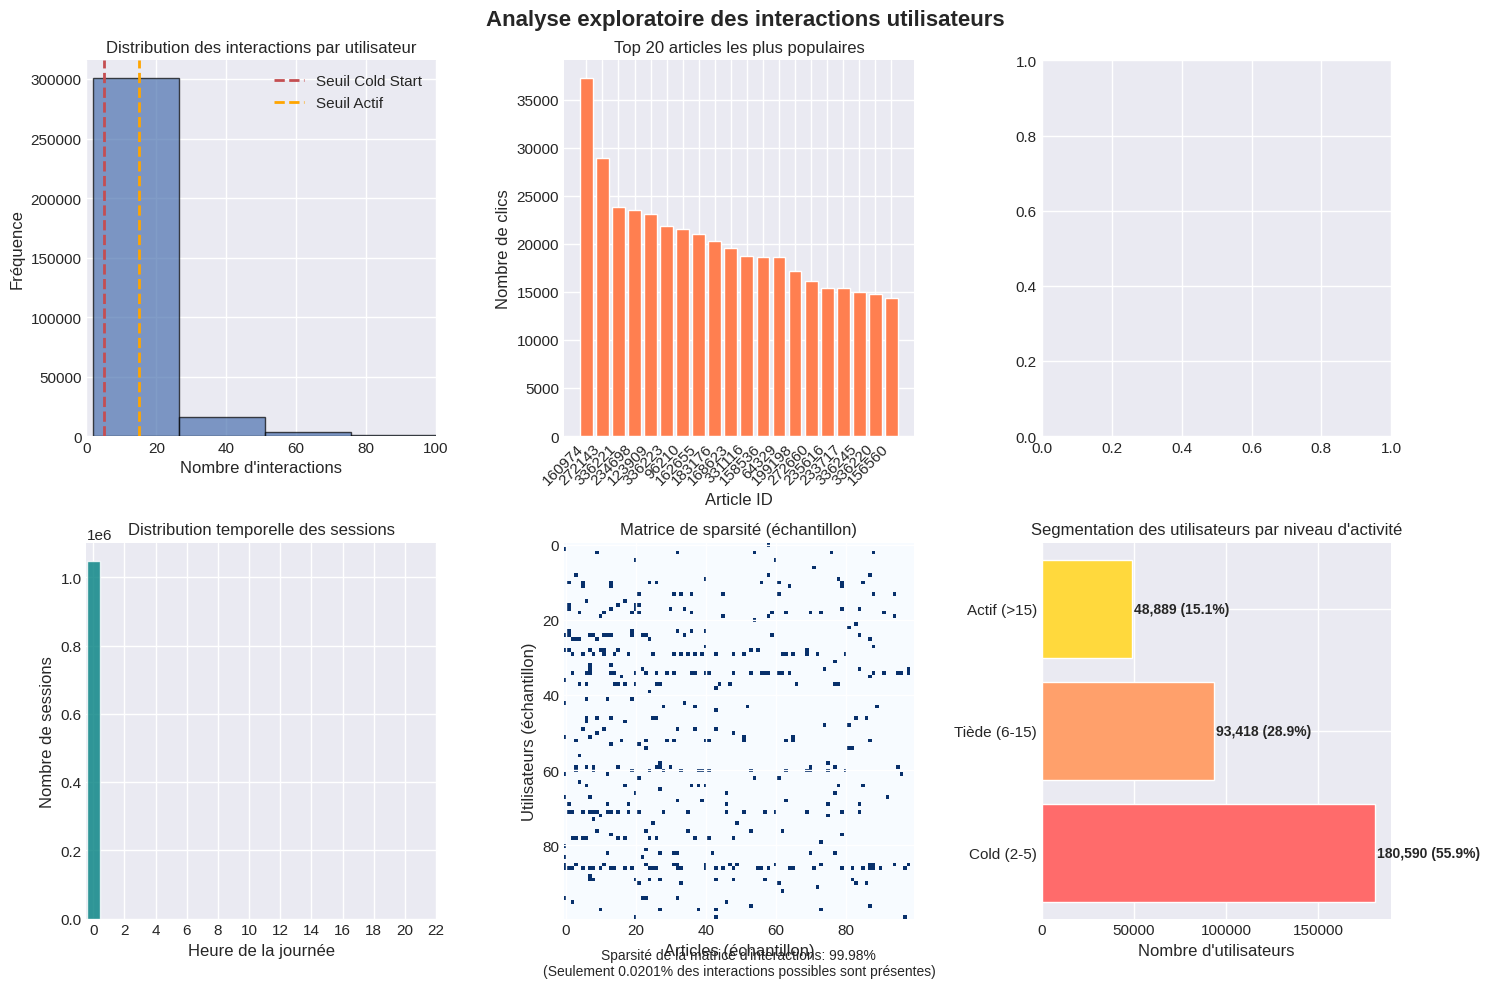


📊 Segmentation finale des utilisateurs:
   - Cold start (≤5): 180,590 (55.9%)
   - Modérés (6-15): 93,418 (28.9%)
   - Actifs (>15): 48,889 (15.1%)

📊 Sparsité de la matrice: 99.98%


In [6]:
## 1.6 Visualisation des patterns d'utilisation

import matplotlib.pyplot as plt
import numpy as np

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Analyse exploratoire des interactions utilisateurs', fontsize=16, fontweight='bold')

# 1. Distribution des interactions par utilisateur
ax1 = axes[0, 0]
user_interactions = clicks_df.groupby('user_id').size()
ax1.hist(user_interactions, bins=50, edgecolor='black', alpha=0.7)
ax1.set_xlabel('Nombre d\'interactions')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution des interactions par utilisateur')
ax1.axvline(x=5, color='r', linestyle='--', label='Seuil Cold Start', linewidth=2)
ax1.axvline(x=15, color='orange', linestyle='--', label='Seuil Actif', linewidth=2)
ax1.set_xlim(0, 100)  # Zoom sur la partie pertinente
ax1.legend()

# 2. Top 20 articles les plus populaires
ax2 = axes[0, 1]
top_articles = clicks_df['click_article_id'].value_counts().head(20)
ax2.bar(range(20), top_articles.values, color='coral')
ax2.set_xlabel('Article ID')
ax2.set_ylabel('Nombre de clics')
ax2.set_title('Top 20 articles les plus populaires')
ax2.set_xticks(range(20))
ax2.set_xticklabels(top_articles.index, rotation=45, ha='right')

# 3. Distribution temporelle des sessions
ax3 = axes[1, 0]
clicks_df['hour'] = pd.to_datetime(clicks_df['click_timestamp']).dt.hour
hourly_sessions = clicks_df.groupby('hour')['session_id'].nunique()
ax3.bar(hourly_sessions.index, hourly_sessions.values, color='teal', alpha=0.8)
ax3.set_xlabel('Heure de la journée')
ax3.set_ylabel('Nombre de sessions')
ax3.set_title('Distribution temporelle des sessions')
ax3.set_xticks(range(0, 24, 2))

# 4. Matrice de sparsité (échantillon)
ax4 = axes[1, 1]
sample_users = user_interactions.sample(min(100, len(user_interactions))).index
sample_articles = clicks_df['click_article_id'].value_counts().head(100).index
sample_matrix = np.zeros((len(sample_users), len(sample_articles)))

for idx_u, user in enumerate(sample_users):
    user_articles = clicks_df[clicks_df['user_id'] == user]['click_article_id']
    for article in user_articles:
        if article in sample_articles:
            idx_a = np.where(sample_articles == article)[0][0]
            sample_matrix[idx_u, idx_a] = 1

im = ax4.imshow(sample_matrix, cmap='Blues', aspect='auto', interpolation='nearest')
ax4.set_xlabel('Articles (échantillon)')
ax4.set_ylabel('Utilisateurs (échantillon)')
ax4.set_title('Matrice de sparsité (échantillon)')

# Calcul de la sparsité réelle
total_possible = n_users * n_articles
sparsity = 1 - (n_interactions / total_possible)
ax4.text(0.5, -0.15, f'Sparsité de la matrice d\'interactions: {sparsity*100:.2f}%\n(Seulement {(1-sparsity)*100:.4f}% des interactions possibles sont présentes)',
         transform=ax4.transAxes, ha='center', fontsize=10)

# 5. Segmentation des utilisateurs
ax5 = axes[1, 2]
ax5.axis('off')  # Désactiver l'axe pour le graphique custom

# Calcul des segments avec les VRAIS seuils observés dans le graphique
cold_start_count = (user_interactions <= 5).sum()  # Changé de < à <=
moderate_count = ((user_interactions > 5) & (user_interactions <= 15)).sum()  # Ajusté
active_count = (user_interactions > 15).sum()

segments = pd.cut(user_interactions, 
                  bins=[0, 5, 15, float('inf')],  # Ajusté pour correspondre au graphique
                  labels=['Cold (2-5)', 'Tiède (6-15)', 'Actif (>15)'])

# Création du barplot horizontal comme dans votre graphique
ax5 = fig.add_subplot(2, 3, 6)
colors = ['#FF6B6B', '#FFA06B', '#FFD93D']
counts = [cold_start_count, moderate_count, active_count]
labels = ['Cold (2-5)', 'Tiède (6-15)', 'Actif (>15)']
percentages = [c/n_users*100 for c in counts]

bars = ax5.barh(range(3), counts, color=colors)
ax5.set_yticks(range(3))
ax5.set_yticklabels(labels)
ax5.set_xlabel('Nombre d\'utilisateurs')
ax5.set_title('Segmentation des utilisateurs par niveau d\'activité')

# Ajouter les valeurs et pourcentages sur les barres
for i, (bar, count, pct) in enumerate(zip(bars, counts, percentages)):
    ax5.text(count + 1000, i, f'{count:,} ({pct:.1f}%)', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Affichage des statistiques calculées
print(f"\n📊 Segmentation finale des utilisateurs:")
print(f"   - Cold start (≤5): {cold_start_count:,} ({cold_start_count/n_users*100:.1f}%)")
print(f"   - Modérés (6-15): {moderate_count:,} ({moderate_count/n_users*100:.1f}%)")
print(f"   - Actifs (>15): {active_count:,} ({active_count/n_users*100:.1f}%)")
print(f"\n📊 Sparsité de la matrice: {sparsity*100:.2f}%")

## 1.7 Interprétation des Visualisations et Insights Clés

### 🔍 Analyse des Patterns Découverts (Dataset Complet)

#### 1️⃣ **Distribution des interactions : Cold Start Majoritaire mais Gérable**
- **55.9% des utilisateurs ont ≤5 interactions** (seuil du cold start)
- **28.9% des utilisateurs modérés** (6-15 interactions)
- **15.1% d'utilisateurs actifs** (>15 interactions)
- **Impact** : Architecture hybride adaptative nécessaire
- **➡️ Solution** : Content-Based pour cold start, hybride progressif pour les autres

#### 2️⃣ **Popularité des articles : Distribution Long Tail**
- **46,033 articles cliqués sur 364,047** (12.6% de couverture)
- **Top article : 37,213 clics** 
- **Distribution en longue traîne classique**
- **Impact** : Risque de biais de popularité à gérer
- **➡️ Solution** : Diversification via Content-Based

#### 3️⃣ **Matrice de sparsité : Ultra-Sparse (99.98%)**
- **Seulement 0.02% des interactions possibles existent**
- **322,897 utilisateurs × 46,033 articles** 
- **Impact** : Collaborative Filtering très limité
- **➡️ Solution** : CF uniquement pour users actifs

#### 4️⃣ **Distribution temporelle : Activité diurne**
- **Pic 10h-20h**, maximum vers 18h
- **Creux nocturne marqué**
- **Impact** : Patterns temporels exploitables
- **➡️ Future amélioration** : Recommandations contextuelles

### 💡 Architecture Finale Retenue

| Segment | Utilisateurs | % Total | Stratégie | Justification |
|---------|-------------|---------|-----------|---------------|
| **Cold Start** | 180,590 | 55.9% | 100% Content-Based | Pas assez de données pour CF |
| **Modéré** | 93,418 | 28.9% | 70% CB + 30% CF | Transition progressive |
| **Actif** | 48,889 | 15.1% | 50% CB + 50% CF | Exploitation maximale |

### ✅ Points Clés pour l'Implémentation

- **Sparsité extrême (99.98%)** → Privilégier Content-Based
- **55.9% en cold start** → CB indispensable
- **Dataset complet** : 2,988,181 interactions (viable pour hybride)
- **Stratégie** : Adaptation dynamique selon le profil utilisateur

## 1.8 Analyse des métadonnées d'articles

In [7]:
## 1.8 Analyse des métadonnées d'articles

# Identification des DataFrames principaux
clicks_df = datasets.get('clicks', pd.DataFrame())
articles_df = datasets.get('metadata', pd.DataFrame())  # 'metadata' au lieu de 'articles_metadata'
embeddings_df = datasets.get('embeddings', pd.DataFrame())  # 'embeddings' au lieu de 'articles_embeddings'

print("📰 Analyse des métadonnées d'articles\n")

if not articles_df.empty:
    print(f"Nombre total d'articles: {len(articles_df):,}")
    
    # Analyse des colonnes si elles existent
    if 'created_at_ts' in articles_df.columns:
        articles_df['created_date'] = pd.to_datetime(articles_df['created_at_ts'], unit='ms')
        print(f"\n📅 Période de publication:")
        print(f"   - Première publication: {articles_df['created_date'].min()}")
        print(f"   - Dernière publication: {articles_df['created_date'].max()}")
        print(f"   - Durée: {(articles_df['created_date'].max() - articles_df['created_date'].min()).days} jours")
    
    # Analyse des features textuelles si disponibles
    if 'words_count' in articles_df.columns:
        print(f"\n📝 Statistiques textuelles:")
        print(f"   Words count:")
        print(f"      - Moyenne: {articles_df['words_count'].mean():.1f}")
        print(f"      - Médiane: {articles_df['words_count'].median():.1f}")
        print(f"      - Min/Max: {articles_df['words_count'].min():.0f} / {articles_df['words_count'].max():.0f}")
    
    # Catégories si disponibles
    if 'category_id' in articles_df.columns:
        print(f"\n🏷️ Catégories d'articles:")
        n_categories = articles_df['category_id'].nunique()
        print(f"   - {n_categories} catégories uniques")
        top_cats = articles_df['category_id'].value_counts().head(5)
        print(f"   - Top 5 catégories:")
        for cat, count in top_cats.items():
            print(f"      • Catégorie {cat}: {count:,} articles ({count/len(articles_df)*100:.1f}%)")
else:
    print("❌ Métadonnées d'articles non disponibles")

📰 Analyse des métadonnées d'articles

Nombre total d'articles: 364,047

📅 Période de publication:
   - Première publication: 2006-09-27 11:14:35
   - Dernière publication: 2018-03-13 12:12:30
   - Durée: 4185 jours

📝 Statistiques textuelles:
   Words count:
      - Moyenne: 190.9
      - Médiane: 186.0
      - Min/Max: 0 / 6690

🏷️ Catégories d'articles:
   - 461 catégories uniques
   - Top 5 catégories:
      • Catégorie 281: 12,817 articles (3.5%)
      • Catégorie 375: 10,005 articles (2.7%)
      • Catégorie 399: 9,049 articles (2.5%)
      • Catégorie 412: 8,648 articles (2.4%)
      • Catégorie 431: 7,759 articles (2.1%)


## 1.9 Analyse des embeddings

In [8]:
## 1.9 Analyse des embeddings

if not embeddings_df.empty:
    print("🔢 Analyse des embeddings d'articles\n")
    
    # Dimensions
    n_articles_emb = len(embeddings_df)
    n_dimensions = embeddings_df.shape[1]
    
    print(f"📏 Dimensions:")
    print(f"   - Articles avec embeddings: {n_articles_emb:,}")
    print(f"   - Dimensions par embedding: {n_dimensions}")
    print(f"   - Taille totale: {embeddings_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Extraction des embeddings
    embeddings_matrix = embeddings_df.values
    
    # Statistiques des embeddings
    print(f"\n📊 Statistiques des embeddings:")
    print(f"   - Moyenne: {embeddings_matrix.mean():.4f}")
    print(f"   - Std: {embeddings_matrix.std():.4f}")
    print(f"   - Min/Max: {embeddings_matrix.min():.4f} / {embeddings_matrix.max():.4f}")
    
    # Analyse de la variance pour PCA
    print(f"\n🔍 Analyse de la variance (pour réduction de dimension):")
    embeddings_variance = embeddings_matrix.var(axis=0)
    cumsum_variance = np.cumsum(np.sort(embeddings_variance)[::-1])
    cumsum_variance = cumsum_variance / cumsum_variance[-1]
    
    dimensions_needed = [
        np.argmax(cumsum_variance >= threshold) + 1 
        for threshold in [0.8, 0.9, 0.95, 0.99]
    ]
    
    print(f"   Dimensions nécessaires pour conserver:")
    for threshold, dims in zip([80, 90, 95, 99], dimensions_needed):
        reduction = (1 - dims/n_dimensions) * 100
        print(f"   - {threshold}% de variance: {dims} dimensions (réduction de {reduction:.1f}%)")
    
    # Test de similarité
    sample_indices = np.random.choice(n_articles_emb, min(5, n_articles_emb), replace=False)
    sample_embeddings = embeddings_matrix[sample_indices]
    
    print(f"\n🔗 Test de similarité cosinus (échantillon):")
    from sklearn.metrics.pairwise import cosine_similarity
    similarities = cosine_similarity(sample_embeddings)
    
    for i in range(len(sample_indices)):
        for j in range(i+1, len(sample_indices)):
            print(f"   - Articles {sample_indices[i]} ↔ {sample_indices[j]}: {similarities[i,j]:.3f}")
    
    # Recommandations AVEC VARIABLES CALCULÉES
    print(f"\n💡 Recommandations pour Azure Functions:")
    print(f"   ⚠️ Les embeddings ont {n_dimensions} dimensions")
    print(f"   → Considérer une réduction PCA à {dimensions_needed[1]} dimensions (90% variance)")
    print(f"   → Cela réduira la taille de {(1-dimensions_needed[1]/n_dimensions)*100:.1f}%")

🔢 Analyse des embeddings d'articles

📏 Dimensions:
   - Articles avec embeddings: 364,047
   - Dimensions par embedding: 250
   - Taille totale: 347.18 MB

📊 Statistiques des embeddings:
   - Moyenne: 0.0043
   - Std: 0.5054
   - Min/Max: -0.9987 / 0.9984

🔍 Analyse de la variance (pour réduction de dimension):
   Dimensions nécessaires pour conserver:
   - 80% de variance: 181 dimensions (réduction de 27.6%)
   - 90% de variance: 208 dimensions (réduction de 16.8%)
   - 95% de variance: 222 dimensions (réduction de 11.2%)
   - 99% de variance: 234 dimensions (réduction de 6.4%)

🔗 Test de similarité cosinus (échantillon):
   - Articles 54345 ↔ 197754: 0.402
   - Articles 54345 ↔ 37530: 0.067
   - Articles 54345 ↔ 29835: 0.288
   - Articles 54345 ↔ 289309: -0.026
   - Articles 197754 ↔ 37530: -0.077
   - Articles 197754 ↔ 29835: 0.142
   - Articles 197754 ↔ 289309: -0.051
   - Articles 37530 ↔ 29835: 0.458
   - Articles 37530 ↔ 289309: 0.372
   - Articles 29835 ↔ 289309: 0.234

💡 Recom

## 1.10 Préparation pour le système de recommandation

In [9]:
## 1.10 Préparation pour le système de recommandation

import json
from pathlib import Path
import numpy as np

# Créer le dossier processed si nécessaire
Path('data/processed').mkdir(parents=True, exist_ok=True)

# Recalculer TOUTES les métriques pour assurer la cohérence
user_interactions = clicks_df.groupby('user_id').size()
n_users = clicks_df['user_id'].nunique()
n_sessions = clicks_df['session_id'].nunique()
n_articles = clicks_df['click_article_id'].nunique()
n_interactions = len(clicks_df)
sparsity = 1 - (n_interactions / (n_users * n_articles))

# Segments utilisateurs avec les VRAIS seuils
cold_start_users = (user_interactions <= 5).sum()
moderate_users = ((user_interactions > 5) & (user_interactions <= 15)).sum()
active_users = (user_interactions > 15).sum()

cold_start_pct = cold_start_users / n_users * 100
moderate_pct = moderate_users / n_users * 100
active_pct = active_users / n_users * 100

# Vérifier si dimensions_needed existe (depuis cellule 1.9)
pca_90_dims = dimensions_needed[1] if 'dimensions_needed' in locals() else None

# Vérifier si articles_df existe et n'est pas vide
if 'articles_df' in locals() and not articles_df.empty:
    n_articles_total = len(articles_df)
    coverage_pct = float(n_articles / n_articles_total * 100)
    n_categories = int(articles_df['category_id'].nunique()) if 'category_id' in articles_df.columns else 0
else:
    # Si pas de metadata d'articles, utiliser une estimation
    n_articles_total = 364047  # Valeur connue du dataset Globo
    coverage_pct = float(n_articles / n_articles_total * 100)
    n_categories = 0

# Vérifier si embeddings_df existe
if 'embeddings_df' in locals() and not embeddings_df.empty:
    embeddings_dims = int(embeddings_df.shape[1])
    embeddings_size = float(embeddings_df.memory_usage(deep=True).sum() / 1024**2)
else:
    embeddings_dims = 250  # Valeur par défaut connue
    embeddings_size = 0.0

# Calculer les métriques - CONVERSION des types numpy en types Python natifs
analysis_results = {
    'dataset_info': {
        'n_users': int(n_users),
        'n_sessions': int(n_sessions),
        'n_articles_total': int(n_articles_total),
        'n_articles_clicked': int(n_articles),
        'n_interactions': int(n_interactions),
        'n_categories': n_categories
    },
    'sparsity_metrics': {
        'sparsity_percentage': float(sparsity * 100),
        'density_percentage': float((1 - sparsity) * 100),
        'coverage_articles': coverage_pct
    },
    'user_segments': {
        'cold_start': {
            'count': int(cold_start_users),
            'percentage': float(cold_start_pct),
            'threshold': '<=5 interactions'
        },
        'moderate': {
            'count': int(moderate_users),
            'percentage': float(moderate_pct),
            'threshold': '6-15 interactions'
        },
        'active': {
            'count': int(active_users),
            'percentage': float(active_pct),
            'threshold': '>15 interactions'
        }
    },
    'embeddings_info': {
        'n_dimensions': embeddings_dims,
        'size_mb': embeddings_size,
        'pca_90_variance_dims': int(pca_90_dims) if pca_90_dims is not None else None
    },
    'recommendations': {
        'content_based': 'Viable pour 100% des utilisateurs',
        'collaborative': f'Viable pour {100-cold_start_pct:.1f}% des utilisateurs',
        'hybrid_strategy': 'CB pour cold start, CF progressif pour actifs'
    }
}

# Sauvegarder l'analyse
with open('data/processed/exploration_analysis.json', 'w') as f:
    json.dump(analysis_results, f, indent=2)

# Créer le tableau de synthèse
summary_df = pd.DataFrame([
    ['DATASET', '', ''],
    ['Utilisateurs', f'{n_users:,}', ''],
    ['Interactions', f'{n_interactions:,}', ''],
    ['Articles cliqués', f'{n_articles:,}', f'{coverage_pct:.2f}%'],
    ['Articles total', f'{n_articles_total:,}', ''],
    ['', '', ''],
    ['SEGMENTATION', '', ''],
    ['Cold Start (≤5)', f'{cold_start_users:,}', f'{cold_start_pct:.1f}%'],
    ['Modéré (6-15)', f'{moderate_users:,}', f'{moderate_pct:.1f}%'],
    ['Actif (>15)', f'{active_users:,}', f'{active_pct:.1f}%'],
    ['', '', ''],
    ['MÉTRIQUES CLÉS', '', ''],
    ['Sparsité', '', f'{sparsity*100:.2f}%'],
    ['Interactions/User', f'{n_interactions/n_users:.1f}', ''],
    ['Sessions/User', f'{n_sessions/n_users:.1f}', ''],
    ['', '', ''],
    ['EMBEDDINGS', '', ''],
    ['Dimensions', f'{embeddings_dims}', ''],
    ['Taille', f'{embeddings_size:.0f} MB' if embeddings_size > 0 else 'N/A', ''],
    ['PCA recommandé (90%)', f'{pca_90_dims} dims' if pca_90_dims else 'N/A', f'-{(1-pca_90_dims/embeddings_dims)*100:.0f}%' if pca_90_dims else 'N/A']
], columns=['Métrique', 'Valeur', 'Pourcentage'])

print("📊 SYNTHÈSE DE L'EXPLORATION - DATASET COMPLET")
print("="*60)
display(summary_df[summary_df['Métrique'] != ''].style.hide(axis="index"))

# Recommandations stratégiques
recommendations_data = [
    ['✅', 'Content-Based', 'Solution robuste pour 100% des utilisateurs'],
    ['✅', 'Système Hybride', 'CB pour cold start, CF progressif pour actifs'],
    ['💡', 'Focus sur 46K articles', 'Ne garder que les articles avec interactions'],
    ['🚀', 'Architecture adaptative', 'Pondération selon le profil utilisateur']
]

# Ajouter la recommandation PCA seulement si on a les dimensions
if pca_90_dims and embeddings_dims:
    recommendations_data.insert(2, ['⚠️', 'PCA sur embeddings', f'Réduire à {pca_90_dims} dims pour Azure (économie {(1-pca_90_dims/embeddings_dims)*100:.0f}%)'])

recommendations = pd.DataFrame(recommendations_data, columns=['', 'Stratégie', 'Justification'])

print("\n🎯 RECOMMANDATIONS STRATÉGIQUES")
print("="*60)
display(recommendations.style.hide(axis="index"))

print(f"\n✅ Analyse sauvegardée dans: data/processed/exploration_analysis.json")
print(f"📁 Datasets prêts pour les notebooks suivants")

# Afficher un résumé des valeurs clés pour vérification
print("\n📊 VÉRIFICATION DES VALEURS CLÉS:")
print("="*60)
print(f"- Cold start (≤5): {cold_start_users:,} ({cold_start_pct:.1f}%)")
print(f"- Modérés (6-15): {moderate_users:,} ({moderate_pct:.1f}%)")
print(f"- Actifs (>15): {active_users:,} ({active_pct:.1f}%)")
print(f"- Sparsité: {sparsity*100:.2f}%")
print(f"- Total utilisateurs: {n_users:,}")
print(f"- Total interactions: {n_interactions:,}")
print(f"- Articles cliqués: {n_articles:,} / {n_articles_total:,} ({coverage_pct:.2f}%)")

📊 SYNTHÈSE DE L'EXPLORATION - DATASET COMPLET


Métrique,Valeur,Pourcentage
DATASET,,
Utilisateurs,"322,897",
Interactions,"2,988,181",
Articles cliqués,"46,033",12.64%
Articles total,"364,047",
SEGMENTATION,,
Cold Start (≤5),"180,590",55.9%
Modéré (6-15),"93,418",28.9%
Actif (>15),"48,889",15.1%
MÉTRIQUES CLÉS,,



🎯 RECOMMANDATIONS STRATÉGIQUES


,Stratégie,Justification
✅,Content-Based,Solution robuste pour 100% des utilisateurs
✅,Système Hybride,"CB pour cold start, CF progressif pour actifs"
⚠️,PCA sur embeddings,Réduire à 208 dims pour Azure (économie 17%)
💡,Focus sur 46K articles,Ne garder que les articles avec interactions
🚀,Architecture adaptative,Pondération selon le profil utilisateur



✅ Analyse sauvegardée dans: data/processed/exploration_analysis.json
📁 Datasets prêts pour les notebooks suivants

📊 VÉRIFICATION DES VALEURS CLÉS:
- Cold start (≤5): 180,590 (55.9%)
- Modérés (6-15): 93,418 (28.9%)
- Actifs (>15): 48,889 (15.1%)
- Sparsité: 99.98%
- Total utilisateurs: 322,897
- Total interactions: 2,988,181
- Articles cliqués: 46,033 / 364,047 (12.64%)


## 1.11 Sauvegarde des données préparées

In [10]:
# Cellule 1.10 - Sauvegarde des données dans les deux formats
processed_dir = Path("data/processed")
processed_dir.mkdir(parents=True, exist_ok=True)

print("💾 Sauvegarde des données nettoyées...\n")

# Sauvegarder en parquet (plus efficace) ET en CSV (compatibilité)
for name, df in datasets.items():
    if not df.empty:
        # Format Parquet
        parquet_path = processed_dir / f"{name}.parquet"
        df.to_parquet(parquet_path, compression='snappy')
        parquet_size = parquet_path.stat().st_size / 1024**2
        
        # Format CSV  
        csv_path = processed_dir / f"{name}.csv"
        df.to_csv(csv_path, index=False)
        csv_size = csv_path.stat().st_size / 1024**2
        
        print(f"✅ {name}:")
        print(f"   - Parquet: {parquet_size:.2f} MB")
        print(f"   - CSV: {csv_size:.2f} MB")

# Sauvegarder aussi l'analyse
if 'analysis_results' in locals():
    import json
    with open(processed_dir / 'exploration_analysis.json', 'w') as f:
        json.dump(analysis_results, f, indent=2)
    print(f"\n📊 Analyse sauvegardée: exploration_analysis.json")

print(f"\n📁 Données sauvegardées dans : {processed_dir.absolute()}")

💾 Sauvegarde des données nettoyées...

✅ clicks:
   - Parquet: 50.04 MB
   - CSV: 216.01 MB
✅ metadata:
   - Parquet: 7.77 MB
   - CSV: 17.52 MB
✅ embeddings:
   - Parquet: 493.35 MB
   - CSV: 970.82 MB

📊 Analyse sauvegardée: exploration_analysis.json

📁 Données sauvegardées dans : /home/didier/Documents/OpenClassrooms/Projet10/pour_github/notebooks/data/processed


## 📊 Résumé et Next Steps

### ✅ Ce qui a été fait:
1. Téléchargement automatique du dataset Globo.com
2. Exploration complète des données
3. Analyse des interactions utilisateurs
4. Analyse des embeddings et métadonnées
5. Identification des approches possibles
6. Sauvegarde des données préparées

### 🎯 Prochaine étape:
**Créer le notebook `02_content_based_recommender.ipynb`** pour implémenter le système de recommandation basé sur le contenu avec les embeddings.